# Supervised Learning

This notebook aims to perform some supervised learning. The goal of this notebook is to create a model that predicts charging times of an electric vehicle (EV). The dataset being used is the EV Watts dataset. For this analysis the primary question arises from the viewpoint of a

## Importing Data

The dataset comes in several csv files. For this analysis the _Sessions_ csv file will be used. 

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

if 'sessions' not in locals():
    sessions = pd.read_csv('evwatts.public.session.csv')
if 'evse' not in locals():
    evse = pd.read_csv('evwatts.public.evse.csv')

df = pd.merge(sessions, evse, how='left', on='evse_id')
del sessions
del evse
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13937235 entries, 0 to 13937234
Data columns (total 18 columns):
 #   Column           Dtype  
---  ------           -----  
 0   session_id       int64  
 1   evse_id          int64  
 2   connector_id     int64  
 3   start_datetime   object 
 4   end_datetime     object 
 5   total_duration   float64
 6   charge_duration  float64
 7   energy_kwh       float64
 8   start_soc        float64
 9   end_soc          float64
 10  flag_id          int64  
 11  metro_area       object 
 12  land_use         object 
 13  region           object 
 14  num_ports        float64
 15  charge_level     object 
 16  venue            object 
 17  pricing          object 
dtypes: float64(6), int64(4), object(8)
memory usage: 1.9+ GB
None


,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170,NaN,NaN,0,Undesignated,Undesignated,Middle Atlantic,2.0,L2,Municipal Building,Undesignated
1,11563,116,116,2020-03-01 10:02:24,2020-03-01 11:08:14,1.096944,1.089722,5.212,NaN,NaN,0,Undesignated,Metro Area,Middle Atlantic,2.0,L2,Medical or Educational Campus,Undesignated
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392,NaN,NaN,0,"Rochester, NY Metro Area",Metro Area,Middle Atlantic,2.0,L2,Municipal Building,Undesignated
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521,NaN,NaN,0,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.0,L2,Municipal Building,Undesignated
4,11566,0,138,2020-02-29 19:09:03,2020-03-01 10:47:16,15.636667,12.658889,80.527,NaN,NaN,0,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.0,L2,Municipal Building,Undesignated


(121137,)


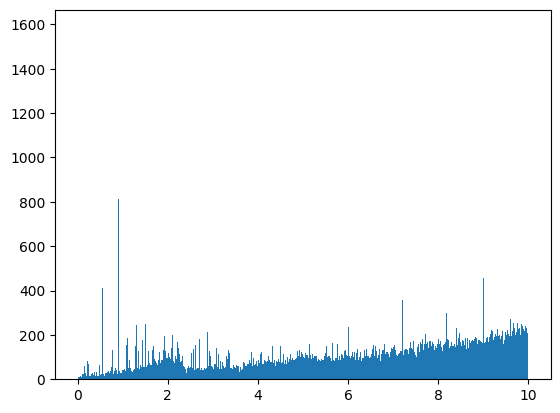

In [27]:
df1 = df.dropna()
x = df1['energy_kwh'] / df1['charge_duration']
x = x.dropna().values
x = x[np.where(x < 10)[0]]
print(x.shape)
plt.hist(x, bins=1000);

Reviewing the data structure we can see that each charging session is annotated using the `session_id` variable. Each session is then linked to an equipment `evse_id` and a connector `connnector_id`. Knowing this information is very useful as nothing is manufactured the same, one charging station could be malfunctioned or deteriorating and performing worse than others. 

A start time and end time are present. These can be used to extract seasonality data or time data, which can be used to check if different times of the day or year might have impacts. While the time itself may not be much of a factor, the time of day or time of year could have an impact due to weather (high humidity, low pressure, etc). Though, we will need to careful as the difference between these two times is a leakage to the charging time.

One of the key variables is the `charge_duration` which tells us how long the car took to charge. On this note, there is also a `total_duration` which is the time that the car is connected to the charger. Logically, these two variables should be highly correlated as `charge_duration` cannot be greater than `total_duration`. It is important to note this variable as it is a variable that needs to be dropped as this will be a data leakage incident if we use the `total_duration`.

Another notable feature is the `energy_kwh`. This is the total amount of energy transferred to the car. This could potentially be a data leakage and most likely is. A car does estimate the amount charge it has remaining and can estimate the total energy it needs. Knowing how much energy is a great predictor of how much charge it will take thus how much time, however, that is __not__ how this was recorded. It won't be used for this analysis.

The `start_soc` and `end_soc` is the starting and ending state of charge. State of charge is the percentage of battery remaining in that car. Another data leakage is present in people don't know the state of charge the car will be in when they finish. Obviously, we a battery is fully charged, it should have a state of 100%. However, there is still a human in the loop making decisions. A human may decide they have enough charge to get to their next location and may end a session before their state is 100%. It'll be important to either remove this feature or filter to only cars that charged to 100%. 

Finally, we have the `flag_id`. This is a maintenance alert that is thrown if something in the charger or car fails. It is unpredictable and only known after charging begins. If a flag is thrown, it means something is wrong and the car may stop charging or slow down considerably. Knowing this flag is data leakage and will not be used in the analysis.

In [2]:
print(f'EVSE IDs:      {len(df.evse_id.unique())}')
print(f'Connector IDs: {len(df.connector_id.unique())}')
print(f'Metro Areas:   {len(df.metro_area.unique())}')
print(f'Land Use:      {len(df.land_use.unique())}')
print(f'Number Ports:  {len(df.num_ports.unique())}')
print(f'Charge Levels: {len(df.charge_level.unique())}')
print(f'Pricing:       {len(df.pricing.unique())}')
print(df.pricing.unique())

EVSE IDs:      38458
Connector IDs: 52662
Metro Areas:   31
Land Use:      4
Number Ports:  3
Charge Levels: 3
Pricing:       4
['Undesignated' 'Free' 'Paid' nan]


### Categorical Data

EVSE and Connector IDs are the only categorical features we have. There is a total of 38,458 unique EVSE IDs and 52,662 Connector IDs. I notice that the number of unique EVSE IDs is just over half the the number of unique connector IDs. I am not an expert on EVs but this leads me to think that there are models of chargers with either 1 or 2 connectors on them. 

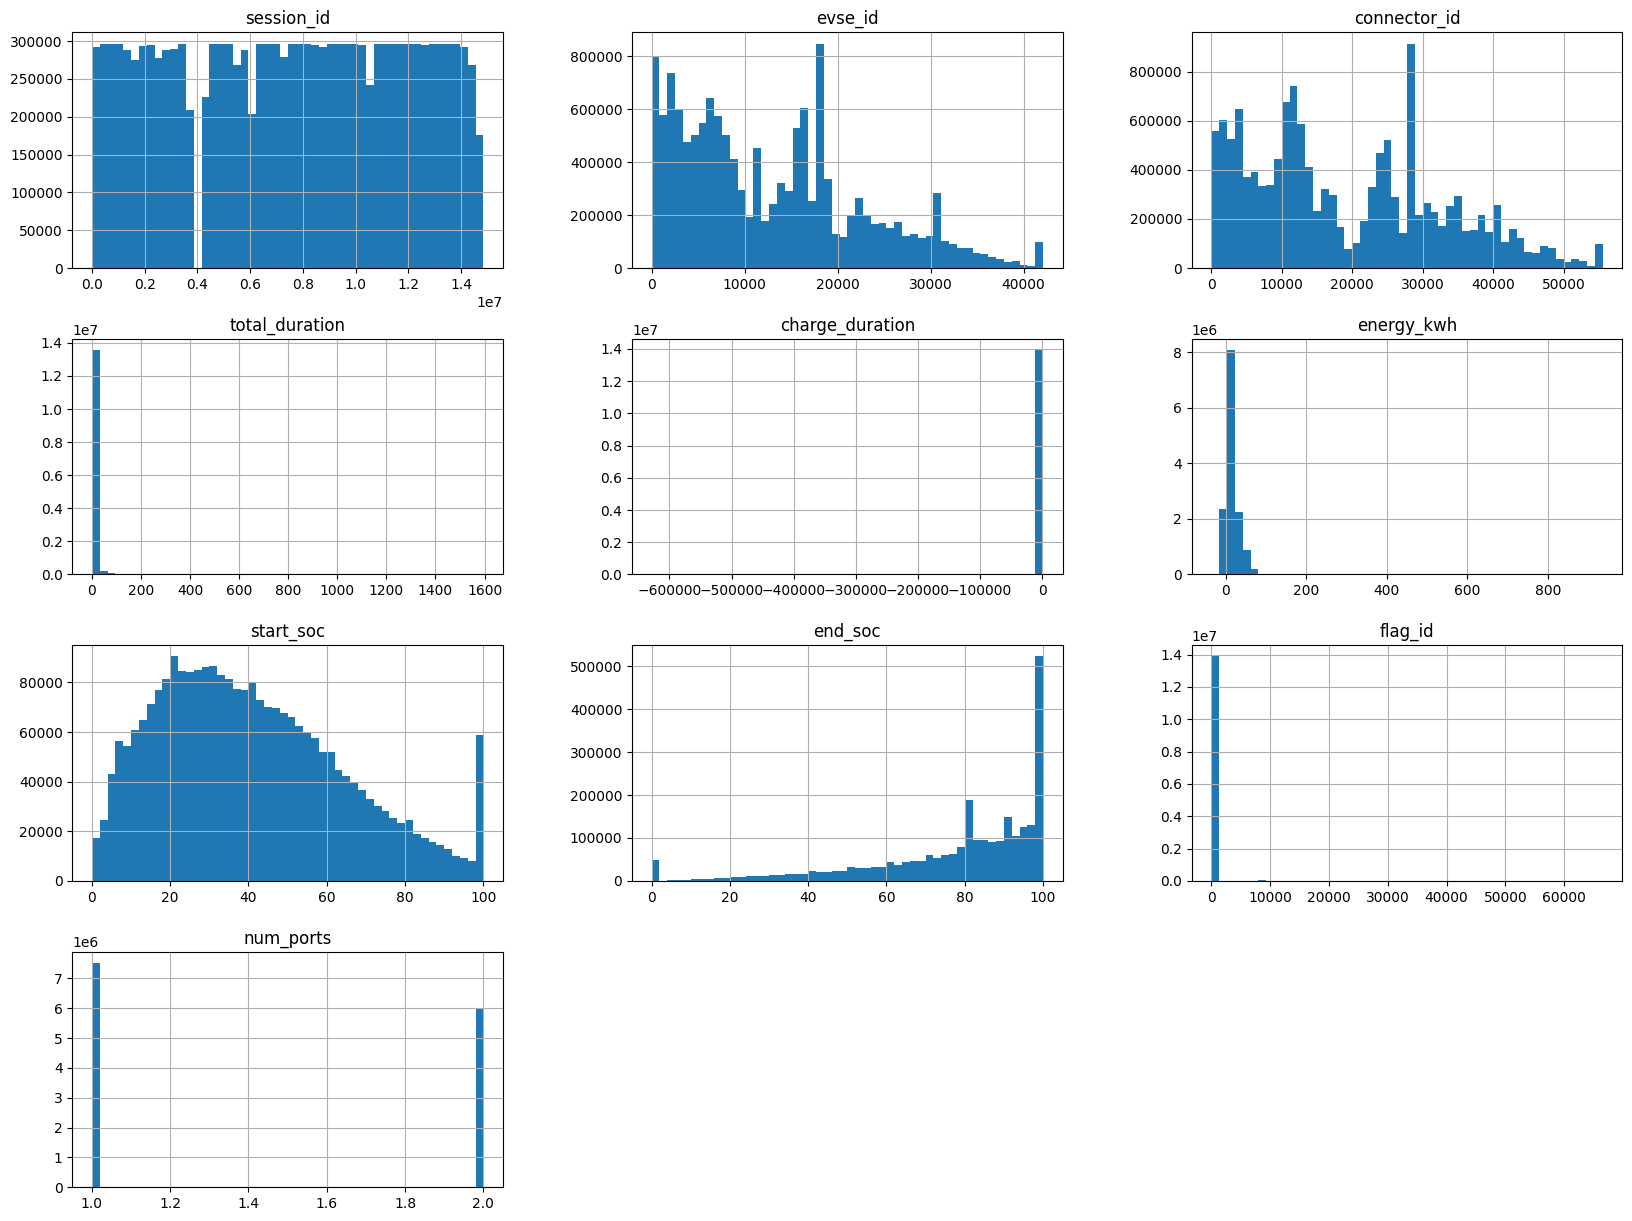

In [3]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20,15));

### Description

Looking at this data we can see that the mean charge duration is 1.85 hours. From the histogram we can see that most people begin charging their vehicles at 20 to 40%. These does appear to be a large set of people starting their charge at or close to 100%. 

## Creating Training and Test Data

To prevent data leakage and to ensure we have meaningful results, it is imparitive that we set aside some of our data for testing purposes. 

In [4]:
import hashlib 
import numpy as np

def test_set_check(identifier: int, test_ratio: float, hash: callable) -> bool:
    '''Checks if instance is splitable or not'''
    
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data: pd.DataFrame, test_ratio: float, id_column: str, hash=hashlib.md5) -> pd.DataFrame:
    '''Splits a dataset into training and test data'''
    
    # Get the id's to split by
    ids = data[id_column]
    
    # Get the test set id's
    in_test_set = ids.apply(lambda x: test_set_check(x, test_ratio, hash))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

df_train, df_test = split_train_test_by_id(df, 0.2, 'session_id')

In [5]:
df_train.head()

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170,NaN,NaN,0,Undesignated,Undesignated,Middle Atlantic,2.0,L2,Municipal Building,Undesignated
2,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392,NaN,NaN,0,"Rochester, NY Metro Area",Metro Area,Middle Atlantic,2.0,L2,Municipal Building,Undesignated
3,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521,NaN,NaN,0,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.0,L2,Municipal Building,Undesignated
5,11567,121,250,2020-03-01 08:33:31,2020-03-01 10:40:24,2.115556,2.110278,7.531,NaN,NaN,0,Undesignated,Metro Area,Middle Atlantic,2.0,L2,Municipal Building,Undesignated
6,11568,119,119,2020-03-01 09:20:25,2020-03-01 10:09:50,0.823056,0.820278,3.101,NaN,NaN,0,Undesignated,Metro Area,Middle Atlantic,2.0,L2,Medical or Educational Campus,Undesignated


## Visualize Insights

In [6]:
# Get state information
import re

# Create new df with unique metro areas
metro_areas = pd.DataFrame({'metro_area': df.metro_area.unique()})

# Get the first city and state
def search_pattern(pattern: str, search_term: str) -> str:
    '''Performs a search and returns variable if present'''
    
    try:
        return re.findall(pattern, search_term)[0]
    except IndexError:
        return search_term
    except TypeError:
        return float('NaN')
    
# Cities
city_pattern = r'[A-Za-z\s]+'
metro_areas['city_ascii'] = metro_areas.metro_area.apply(lambda x: search_pattern(city_pattern, x))

# # States
state_pattern = r', ([A-Z]{2})'
metro_areas['state_id'] = metro_areas.metro_area.apply(lambda x: search_pattern(state_pattern, x))

# Get FIPS information (from milestone I project)
states_df = pd.read_csv('assets/states_df.csv')
uscities = pd.read_csv('assets/simplemaps_uscities_basicv1.90/uscities.csv')

# Merge
metro_areas = pd.merge(
    metro_areas, 
    uscities[['city_ascii', 'state_id', 'lat', 'lng']], 
    how='left',
    on=['state_id', 'city_ascii']
)
df_train_fips = pd.merge(df_train, metro_areas[['metro_area', 'lat', 'lng']], on='metro_area')
df_train_fips.head()

,session_id,evse_id,connector_id,start_datetime,end_datetime,total_duration,charge_duration,energy_kwh,start_soc,end_soc,flag_id,metro_area,land_use,region,num_ports,charge_level,venue,pricing,lat,lng
0,11562,5,5,2020-03-01 09:37:44,2020-03-01 11:14:59,1.621389,1.615556,6.170,NaN,NaN,0,Undesignated,Undesignated,Middle Atlantic,2.0,L2,Municipal Building,Undesignated,NaN,NaN
1,11564,72,72,2020-03-01 10:06:08,2020-03-01 11:08:10,1.033611,1.024722,3.392,NaN,NaN,0,"Rochester, NY Metro Area",Metro Area,Middle Atlantic,2.0,L2,Municipal Building,Undesignated,43.1680,-77.6162
2,11565,1,1,2020-03-01 10:01:12,2020-03-01 11:07:09,1.099722,1.076111,6.521,NaN,NaN,0,"Albany-Schenectady-Troy, NY Metro Area",Metro Area,Middle Atlantic,2.0,L2,Municipal Building,Undesignated,42.6664,-73.7987
3,11567,121,250,2020-03-01 08:33:31,2020-03-01 10:40:24,2.115556,2.110278,7.531,NaN,NaN,0,Undesignated,Metro Area,Middle Atlantic,2.0,L2,Municipal Building,Undesignated,NaN,NaN
4,11568,119,119,2020-03-01 09:20:25,2020-03-01 10:09:50,0.823056,0.820278,3.101,NaN,NaN,0,Undesignated,Metro Area,Middle Atlantic,2.0,L2,Medical or Educational Campus,Undesignated,NaN,NaN


In [7]:
df_train_fips = df_train_fips[df_train_fips.charge_duration > 0]
source = df_train_fips[['metro_area', 'charge_duration']].groupby('metro_area').mean().reset_index()
source = pd.merge(source, df_train_fips[['lat', 'lng', 'metro_area']], on='metro_area', how='inner').drop_duplicates().reset_index(drop=True)
source

,metro_area,charge_duration,lat,lng
0,"Albany-Schenectady-Troy, NY Metro Area",2.322243,42.6664,-73.7987
1,"Ann Arbor, MI Metro Area",2.592830,42.2759,-83.7310
2,"Austin-Round Rock-Georgetown, TX Metro Area",3.097487,30.3005,-97.7522
3,"Baltimore-Columbia-Towson, MD Metro Area",2.802040,39.3051,-76.6144
4,"Boston-Cambridge-Newton, MA-NH Metro Area",3.063812,42.3188,-71.0852
5,"Boulder, CO Metro Area",2.247817,40.0248,-105.2524
6,"Burlington-South Burlington, VT Metro Area",2.508694,44.4876,-73.2316
7,"Chicago-Naperville-Elgin, IL-IN-WI Metro Area",3.857366,41.8375,-87.6866
8,"Dallas-Fort Worth-Arlington, TX Metro Area",4.935539,32.7935,-96.7667
9,"Denver-Aurora-Lakewood, CO Metro Area",2.238245,39.7620,-104.8758


In [10]:
import altair as alt
import vega_datasets

# Get states topo
states = alt.topo_feature(vega_datasets.data.us_10m.url, feature='states')
#source = df_train_fips[['metro_area', 'charge_duration']].groupby('metro_area').mean().reset_index()

background = alt.Chart(states).mark_geoshape(
    fill="lightgray",
    stroke="white"
).properties(
    width=750,
    height=500
).project("albersUsa")

points = alt.Chart(source).mark_circle().encode(
    latitude='lat',
    longitude='lng',
    size=alt.Size("charge_duration:Q").legend(None).scale(range=[0, 1000]),
    tooltip=['metro_area', alt.Tooltip('charge_duration', format='.2f')]
)


(background + points).properties(title='Mean Charge Duration By Metro Area')

alt.LayerChart(...)

In [11]:
# Data Cleaning
df_train_clean = df_train.copy()

# Drop na function
def deal_with_na(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to modularize the workings of na's'''
    
    # Remove undesignated rows
    df = df[df.pricing != 'Undesignated']
    df = df[df.metro_area != 'Undesignated']
    
    # Assume charge durations < 0 are false
    df = df[df.charge_duration >= 0]
    
    # Check the end_soc - start_soc
    # df = df[(df.end_soc - df.start_soc) > 0]

    
    return df.dropna()

# Drop columns function
def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to drop columns and explain why'''
    
    # For sure columns
    df = df.drop(columns=['session_id'])      # Not Needed: Index of data. Don't need for predictions
    df = df.drop(columns=['end_datetime'])    # Leakage: knowing start/end datetimes is insight to total time
    df = df.drop(columns=['total_duration'])  # Leakage: Knowing total duration is directly linked to charge duration
    df = df.drop(columns=['flag_id'])         # Leakage: Maintenance codes are signs of trouble (not charging)
                                              #          and are only seen after a prediction is made
    df = df.drop(columns=['region'])          # Not Needed: Per Matt's demo
    
    # Iffy columns
    df = df.drop(columns=['energy_kwh'])      # Leakage: Knowing the energy received could be insight to total 
                                              #          time. Though we know the start soc which. 
    df = df.drop(columns=['end_soc'])         # Leakage: Might need this. Though I might use it later to filter 
                                              #          to only end soc > 95% or something
    df = df.drop(columns=['charge_level'])    # Not Needed: idk... it makes it slightly easier and might be leakage
        
    return df
    
    

def clean_date_column(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to modify the date'''
    
    # Clean up date
    df.start_datetime = pd.to_datetime(df.start_datetime)
    df['year'] = df.start_datetime.dt.year
    df['month'] = df.start_datetime.dt.month
    df['day'] = df.start_datetime.dt.day
    df['hour'] = df.start_datetime.dt.hour
    df['day_of_year'] = df.start_datetime.dt.day_of_year
    df['quarter'] = df.start_datetime.dt.quarter
    df['weekday'] = df.start_datetime.dt.weekday
    df['week_num'] = df.start_datetime.dt.day_of_year // 7
    
    # Drop the original date
    df = df.drop(columns=['start_datetime'])
    
    return df

def change_data_types(df: pd.DataFrame) -> pd.DataFrame:
    '''Corrects data types'''
    
    df.num_ports = df.num_ports.astype(int)  # Can only have integer ports
    
    return df
    
# Function for cleaning
def clean_dataset(df: pd.DataFrame) -> pd.DataFrame:
    '''Function to clean dataset'''
    # Filter data
    df = df[(df.end_soc - df.start_soc) > 0]  # Anomalies
    df = df[df.end_soc >= 0.95]  # Anything before this, the operator disconnected before finishing
    df = df[df.charge_duration <= 1]  # People be leaving these on the chargers
    
    # Drop data leak columns
    df = drop_columns(df)
    
    # Deal with NaN's
    df = deal_with_na(df)
    
    # Clean the date
    df = clean_date_column(df)
    
    # Data types
    df = change_data_types(df)
    
    return df

df_train_clean = clean_dataset(df_train_clean)
df_train_clean.head()

,evse_id,connector_id,charge_duration,start_soc,metro_area,land_use,num_ports,venue,pricing,year,month,day,hour,day_of_year,quarter,weekday,week_num
136055,819,1463,0.353333,55.0,"Boston-Cambridge-Newton, MA-NH Metro Area",Metro Area,1,Corridor,Free,2020,5,29,18,150,2,4,21
136056,819,1463,0.411111,73.0,"Boston-Cambridge-Newton, MA-NH Metro Area",Metro Area,1,Corridor,Free,2020,5,29,18,150,2,4,21
136057,819,1463,0.347778,40.0,"Boston-Cambridge-Newton, MA-NH Metro Area",Metro Area,1,Corridor,Free,2019,11,14,10,318,4,3,45
136060,819,1463,0.994167,49.0,"Boston-Cambridge-Newton, MA-NH Metro Area",Metro Area,1,Corridor,Free,2020,1,28,18,28,1,1,4
136135,819,1463,0.718889,30.0,"Boston-Cambridge-Newton, MA-NH Metro Area",Metro Area,1,Corridor,Free,2020,7,25,17,207,3,5,29


In [12]:
# Feature Scaling
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer, FunctionTransformer, MultiLabelBinarizer

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names: list):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names].values
    
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = MultiLabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)
    
    
string_converter = FunctionTransformer(lambda x: x.astype(str), validate=False)

# Select features
num_features = ['start_soc', 'year']
cat_features = ['evse_id', 'connector_id', 'metro_area', 'land_use', 'num_ports', 'venue', 'pricing', 'month', 'day', 'hour', 'day_of_year', 'quarter', 'weekday', 'week_num']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_features)),
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_features)),
    ('convert_to_string', string_converter),
    ('label_binarizer', MyLabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

X_train = full_pipeline.fit_transform(df_train_clean.drop(columns=['charge_duration']))
X_train.shape

(533855, 3953)

In [13]:
# Get the y data
y_train = np.array(df_train_clean['charge_duration'])
del df_train_clean
y_train.shape

(533855,)

In [14]:
# Save X_train and y_train
np.save('X_train_filtered.npy', X_train)
np.save('y_train_filtered.npy', y_train)

In [ ]:
# Save X and y for easier use
# np.save('X_train.npy', X_train)
# np.save('y_train.npy', y_train)

In [15]:
# training set
df_test_cleaned = clean_dataset(df_test)

In [16]:
X_test = full_pipeline.transform(df_test_cleaned.drop(columns=['charge_duration']))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['10414', '1145', '1946', '29880', '29996', '30222', '3055', '33988', '34015', '34027', '37320', '37397', '37496', '37649', '37650', '37789', '41032', '41056', '41083', '41822', '41852', '41912', '42073', '46664', '46702', '46703', '46723', '50302', '50447', '50525', '50539', '50548', '50560', '50611', '50744', '50776', '50839', '50840', '50841', '50928', '51008', '51011', '6127'] will be ignored
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [17]:
X_test.shape

(135844, 3953)

In [18]:
y_test = np.array(df_test_cleaned['charge_duration'])
y_test
y_test.shape

(135844,)

In [19]:
np.save('X_test_filtered.npy', X_test)
np.save('y_test_filtered.npy', y_test)